In [ ]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import numpy.matlib as matlib
import glob
import re
import os
import tensorflow as tf
import sys
import pickle
sess = tf.InteractiveSession()

In [63]:
def downsampleByTwo(img):
        tmp = np.array(img)
        # if the number of rows is odd, pad with a row of zeros
        if (tmp.shape[0] & 0x01):
            tmp = np.vstack([tmp, np.zeros((1, tmp.shape[1]))])

        if (tmp.shape[1] & 0x01):
            tmp = np.hstack([tmp, np.zeros((tmp.shape[0], 1))])

        ret = np.zeros(np.array(tmp.shape) / 2)

        for i in range(tmp.shape[0]):
            for j in range(tmp.shape[1]):
                ret[i/2,j/2] = .25 * tmp[i,j]

        return ret

def preprocessImage(img):
#     edges = ndimage.filters.sobel(img)
#     opening = ndimage.morphology.binary_opening(edges, structure=np.ones((2,2)))
    blurred = ndimage.gaussian_filter(img, 3)
    edgesX = ndimage.sobel(blurred, axis=0)
    edgesY = ndimage.sobel(blurred, axis=1)
    edges = np.sqrt(edgesX ** 2 + edgesY ** 2)
    ds = downsampleByTwo(edges)
    ds = downsampleByTwo(ds)
    ds = downsampleByTwo(ds)
    return ds

def readInFile(fName, preprocess=True):
    data = pd.read_csv(fName, index_col=0, dtype='object')

    ret = []
    
    isTestSet = False
    if 'species' in data:
        isTestSet = True

    marginCols = ['margin{0}'.format(i) for i in range(1, 65)]
    textureCols = ['texture{0}'.format(i) for i in range(1, 65)]
    shapeCols = ['shape{0}'.format(i) for i in range(1, 65)]

    labelMap = None
    if isTestSet:
        ## Generate one hot encoding for species
        classNames = sorted(np.unique(data['species']))
        numClasses = len(classNames)
        labelMap = {k:i for i,k in enumerate(classNames)}

    

    columnGroups = [marginCols, textureCols, shapeCols]
    for r in data.iterrows():
        caseId = r[0]
        print '\r','{0:4d}'.format(caseId),
        sys.stdout.flush()
        ret.append([caseId])
        
        if isTestSet:
            # Generate one hot encoding for species
            oneHot = np.zeros((numClasses,))
            oneHot[labelMap[r[1]['species']]] = 1.0
            classId = labelMap[r[1]['species']]
            ret[-1].append(classId)
            ret[-1].append(oneHot)

        for col in columnGroups:
            curr = r[1][col]
            ret[-1].append(np.array([float(x) for x in curr]))

        img = ndimage.imread('data/images/{0}.jpg'.format(caseId)) / 255.0
        if preprocess:
            img = preprocessImage(img)
        ret[-1].append(img)
        ret[-1].append(img.shape[0])
        ret[-1].append(img.shape[1])
        
    columns = ['caseId', 'classId', 'oneHot', 'margin', 
               'textureCols', 'shape', 'img', 'height', 
               'width']
    if not isTestSet:
        columns = columns[:1] + columns[3:]
    return pd.DataFrame(ret, columns=columns), labelMap
    

if not os.path.exists('trainingData.p'):
    trainData, labelMap = readInFile('data/train.csv')
    testData, _ = readInFile('data/test.csv')
    
    pd.to_pickle(trainData, 'trainingData.p')
    pd.to_pickle(testData, 'testingData.p')
    with open('labelMap.p','w') as fileOut:
        pickle.dump(labelMap, fileOut)
else:
    trainData = pd.read_pickle('trainingData.p')
    testData = pd.read_pickle('testingData.p')
    with open('labelMap.p', 'r') as fileIn:
        labelMap = pickle.load(fileIn)
    
class LeafData:
    '''
    Takes in a dataframe of samples
    '''
    def __init__(self, data, testSplit=.3, numClasses=None, isTest=False):
        self._isTest = isTest
        if not self._isTest:
            if numClasses:
                self.numClasses = numClasses
            else:
                self.numClasses = np.max(data.iloc[0]['oneHot'].shape)
            
            data = data[data['classId'] < self.numClasses]
        else:
            testSplit=1.0
 
        # Make sure that there is an even number of train and test cases
        testSelector = []
        
        if not self._isTest:
            for i in range(self.numClasses):
                currClass = data[data['classId'] == i]
                currClass
                numTestItems = int(len(currClass) * testSplit)
                testSelector += list(np.random.choice(currClass.index, numTestItems,
                                                replace=False))


            self._testCases = data.loc[testSelector].copy(deep=True)
            trainCaseSelector = list(set(data.index) - set(testSelector))
            self._trainCases = data.loc[trainCaseSelector].copy(deep=True)
            self._trainCases = self._trainCases.sample(frac=1.0)
        else:
            self._testCases = data.copy(deep=True)
            self._trainCases = pd.DataFrame(None, columns=self._testCases.columns)
                
        self._trainIndex = 0
        
        self._maxWidth = np.max(data['width'])
        self._maxHeight = np.max(data['height'])


        # Define the height as around twice the max image height/width
        # but make sure it's divisible by 4
        self.normImgWidth = 96
        self.normImgHeight = 96
        
        # Combine the shape, texture and margin columns
        self._trainCases['mergedData'] = self._mergeMarginTextureShape(self._trainCases)
        self._testCases['mergedData'] = self._mergeMarginTextureShape(self._testCases)
        
        self.mergedDataLength = len(self._testCases.iloc[0]['mergedData'])
        
        if not self._isTest:
            self._genImageWhitenTransform()
            self._genHistWhitenTransform()
            pass

    def _mergeMarginTextureShape(self, cases):
        histData = []
        for r in cases.iterrows():
            caseId = r[0]
            data = r[1]
            histData.append(np.hstack([data[x] for x in ['margin', 'textureCols', 'shape']]))
        return histData
    
    def _genImageWhitenTransform(self):
        numImages = 10000
        img, _, y = self.getTrainBatch(numImages)
        img = np.reshape(img, [-1, self.normImgHeight * self.normImgWidth])
        img = img.T
        self._imgWhitenMeans = np.expand_dims(np.mean(img, axis=-1), -1)
        img = img - np.matlib.repmat(self._imgWhitenMeans, 1, numImages)
        self._covar = img.dot(img.T)
        
        w, v = np.linalg.eigh(self._covar)
        maxEigval = w[-1]
        ratio = 1e-2
        numEigVals = np.sum(w > maxEigval * ratio)
        w_r = w[-numEigVals:]
        v_r = v[:, -numEigVals:]

        self._imgWhitenFilter = np.sqrt(numImages-1) * v_r.dot(np.diag(w_r ** -.5)).dot(v_r.T)
        self._imgDewhitenFilter = 1/np.sqrt(numImages-1) * v_r.dot(np.diag(w_r ** .5)).dot(v_r.T)
    
    def _genHistWhitenTransform(self):
        ## TODO: Change this to use the 'mergedData' column
        histData = []
        for r in self._trainCases.iterrows():
            caseId = r[0]
            data = r[1]
            histData.append(np.hstack([data[x] for x in ['margin', 'textureCols', 'shape']]))

        histData = np.array(histData).T
        numSamples = len(self._trainCases)
        self._histWhitenMean = np.expand_dims(np.mean(histData, axis =-1), -1)
        histZeroMean = histData - np.matlib.repmat(self._histWhitenMean, 1, numSamples)
        histCovar = histZeroMean.dot(histZeroMean.T)
        w, v = np.linalg.eigh(histCovar)

        maxEigVal = w[-1]
        ratio = 1e-2
        numEigVals = np.sum(w > w[-1] * ratio)
        w_r = w[-numEigVals:]
        v_r = v[:,-numEigVals:]

        self._histWhitenFilter = np.sqrt(numSamples-1) * v_r.dot(np.diag(w_r ** -.5)).dot(v_r.T)
        self._histDewhitenFilter = 1/np.sqrt(numSamples-1) * v_r.dot(np.diag(w_r ** .5)).dot(v_r.T)      

    def whitenImageSamples(self, img):
        tmp = np.reshape(img, (-1, self.normImgHeight * self.normImgWidth))
        tmp = tmp.T
        zeroMean = tmp - np.matlib.repmat(self._imgWhitenMeans, 1, tmp.shape[1])
        whitened = self._imgWhitenFilter.dot(zeroMean)
        tmp = whitened.T
        return np.reshape(tmp, (-1, self.normImgHeight, self.normImgWidth))
    
    def whitenHistSamples(self, hist):
        tmp = hist.T
        zeroMean = tmp - np.matlib.repmat(self._histWhitenMean, 1, tmp.shape[1])
        whitened = self._histWhitenFilter.dot(zeroMean)
        return whitened.T

    def getTrainBatch(self, n):
        y = np.zeros((n, self.numClasses))
        img = np.zeros((n, self.normImgHeight, self.normImgWidth))
        merged = np.zeros((n, self.mergedDataLength))
        
        for i in range(n):
            if self._trainIndex >= len(self._trainCases):
                self._trainIndex = 0
                self._trainCases = self._trainCases.sample(frac=1.0)

            currCase = self._trainCases.iloc[self._trainIndex]
            currImg = np.squeeze(currCase['img'])
            rot = np.random.random(1) * 360
            currImg = ndimage.rotate(currImg, rot)
            imgHeight = currImg.shape[0]
            imgWidth = currImg.shape[1]

            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim))
            
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currImg
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim)
            tmpImg = ndimage.zoom(tmpImg, targetSize)

            img[i, :, :] = tmpImg

            y[i, :] = currCase['oneHot'][:self.numClasses]
            merged[i,:] = currCase['mergedData']
            
            self._trainIndex += 1
            
            
        return img, merged, y
    
    def getTestData(self, caseId=None):
        if caseId == None:
            testCases = self._testCases
        else:
            testCases = self._testCases.loc[self._testCases['caseId'] == caseId]

        y = None
        if not self._isTest:
            y = np.zeros((len(testCases), self.numClasses))
        img = np.zeros((len(testCases), self.normImgHeight, self.normImgWidth))
        merged = np.zeros((len(testCases), self.mergedDataLength))

            
        for i in range(len(testCases)):
            currCase = testCases.iloc[i]
            imgHeight = currCase['height']
            imgWidth = currCase['width']
            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim))
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currCase['img']
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim)
            img[i, :, :] = ndimage.zoom(tmpImg, targetSize)

            if not self._isTest:
                y[i, :] = currCase['oneHot'][:self.numClasses]
            merged[i, :] = currCase['mergedData']
            
        return img, merged, y
        
        
data = LeafData(trainData, testSplit=.3)
test = LeafData(testData, isTest=True)


1583    2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

<IPython.core.display.Javascript object>


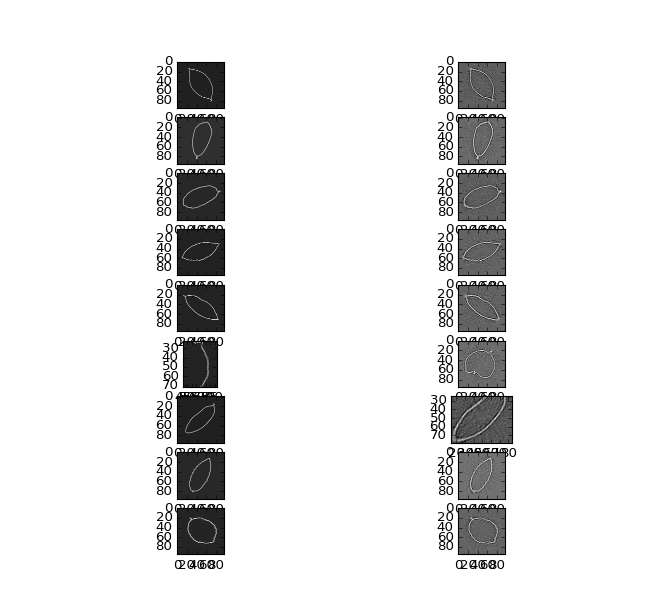

In [64]:
img, hist, y = data.getTrainBatch(9)
whitened = data.whitenImageSamples(img)
plt.figure()
for i in range(img.shape[0]):
    plt.subplot(img.shape[0], 2, 2*i + 1)
    plt.imshow(img[i,:,:], cmap='gray')
    plt.subplot(img.shape[0], 2, 2*i + 2)
    plt.imshow(whitened[i,:,:], cmap='gray')

Defining Graph
Conv2D x Tensor("imgPlaceHolder_7:0", shape=(?, 96, 96, 1), dtype=float32)
Conv2D W Tensor("w_conv1_7/read:0", shape=(9, 9, 1, 8), dtype=float32)
Max_pool x Tensor("pool1_relu_7:0", shape=(?, 96, 96, 8), dtype=float32)
convLayer pool Tensor("pool1_maxPool_7:0", shape=(?, 48, 48, 8), dtype=float32)
Conv2D x Tensor("pool1_maxPool_7:0", shape=(?, 48, 48, 8), dtype=float32)
Conv2D W Tensor("w_conv2_7/read:0", shape=(9, 9, 8, 16), dtype=float32)
Max_pool x Tensor("pool2_relu_7:0", shape=(?, 48, 48, 16), dtype=float32)
convLayer pool Tensor("pool2_maxPool_7:0", shape=(?, 24, 24, 16), dtype=float32)
24 24
pool_flat Tensor("flatten_7:0", shape=(?, 9216), dtype=float32) (?, 9216)
fcHist2 Tensor("fcHist2_relu_7:0", shape=(?, 32), dtype=float32)
combined Tensor("combined_7:0", shape=(?, 9248), dtype=float32)
Defining Loss Function
Initializing Vars


<IPython.core.display.Javascript object>


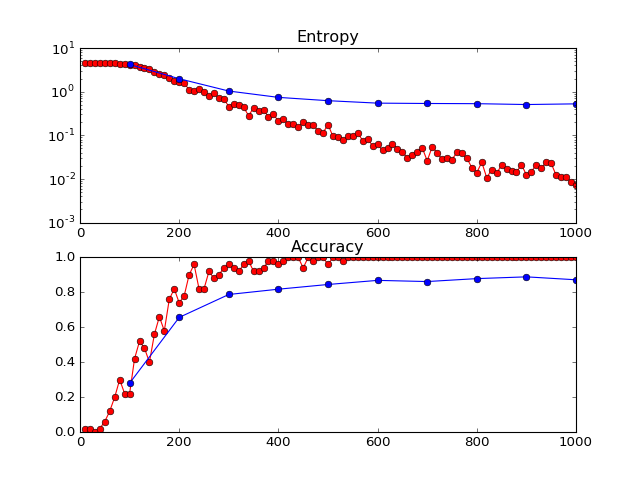

Starting Learning


In [74]:

learningRate = 1e-3
regConst = 1000.0

regl2 = tf.contrib.layers.l2_regularizer(regConst)

print 'Defining Graph'

def weight_variable(shape, name=None): 
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    print 'Conv2D x', x
    print 'Conv2D W', W
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    print 'Max_pool x', x
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)

def convLayer(x, w, b, name=None):
    conv = tf.nn.relu(conv2d(x, w, name=name+'_conv2d') + b, name=name+'_relu')
    pool = max_pool_2x2(conv, name=name+'_maxPool')
    print 'convLayer pool', pool
    return pool

x = tf.placeholder(tf.float32, shape=[None, data.normImgHeight, data.normImgWidth, 1], name='imgPlaceHolder')
labels = tf.placeholder(tf.float32, shape=[None, data.numClasses], name='labelPlaceHolder')
hists = tf.placeholder(tf.float32, shape=[None, data.mergedDataLength], name='histogramInfo')

## Layer definitions
# Layer 1 - Convolutional
kernelSize = 9
numOutputs = 8
numInputChannels = 1
W_conv1 = weight_variable([kernelSize, kernelSize, 
                           numInputChannels, numOutputs], name='w_conv1')
b_conv1 = bias_variable([numOutputs], name='b_conv1')

pool1 = convLayer(x, W_conv1, b_conv1, name='pool1')

outputWidth = data.normImgWidth / 2
outputHeight = data.normImgHeight / 2

# Layer 2 - Convolutional
kernelSize = 9
numInputChannels = numOutputs
numOutputs = 16

W_conv2 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv2')
b_conv2 = bias_variable([numOutputs], name='b_conv2')

pool2 = convLayer(pool1, W_conv2, b_conv2, name='pool2')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2

# # Layer 3 - Convolutional
# kernelSize = 3
# numInputChannels = numOutputs
# numOutputs = 8

# W_conv3 = weight_variable([kernelSize, kernelSize,
#                            numInputChannels, numOutputs], name='w_conv3')
# b_conv3 = bias_variable([numOutputs], name='b_conv3')

# pool3 = convLayer(pool2, W_conv3, b_conv3, name='pool3')

# outputWidth = outputWidth / 2
# outputHeight = outputHeight / 2

####
#### Layers for histogram
####

# Fully connected layer 1
numHistNeuronsOutput = 32
w_hist1 = weight_variable([data.mergedDataLength, numHistNeuronsOutput], name='w_hist1')
b_hist1 = bias_variable([numHistNeuronsOutput], name='b_hist1')
fcHist1 = tf.nn.relu(tf.matmul(hists, w_hist1, name='fcHist1_matmul') + b_hist1, name='fcHist1_relu')

w_hist2 = weight_variable([numHistNeuronsOutput, numHistNeuronsOutput], name='w_hist2')
b_hist2 = bias_variable([numHistNeuronsOutput], name='b_hist2')
fcHist2 = tf.nn.relu(tf.matmul(fcHist1, w_hist2, name='fcHist2_matmul') + b_hist2, name='fcHist2_relu')


####
####
####

# Layer 4 - Fully connected
fcNeurons1 = 128
print outputWidth, outputHeight

W_fc1 = weight_variable([outputWidth * outputHeight *numOutputs + numHistNeuronsOutput, fcNeurons1], name='w_fc1')
b_fc1 = bias_variable([fcNeurons1], name='b_fc1')

pool_flat = tf.reshape(pool2, [-1, outputWidth * outputHeight * numOutputs], name='flatten')
print 'pool_flat', pool_flat, pool_flat.get_shape()
print 'fcHist2', fcHist2
combined = tf.concat(1, [pool_flat, fcHist2], name='combined')
# combined = tf.concat([pool_flat, fcHist2], 1, name='combined')
print 'combined', combined
fc1 = tf.nn.relu(tf.matmul(combined, W_fc1, name='fc1_matmul') + b_fc1, name='fc1_relu')

# fc1 = tf.nn.relu(tf.matmul(pool_flat, W_fc1, name='fc1_matmul') + b_fc1, name='fc1_relu')
# print 'Pool3', pool2
# print 'Pool3_flat', pool_flat, outputWidth, outputHeight, numOutputs


# # Layer 4 - Fully connected
# fcNeurons2 = 128
# W_fc2 = weight_variable([fcNeurons1, fcNeurons2], name='w_fc2')
# b_fc2 = bias_variable([fcNeurons2], name='b_fc2')

# fc2 = tf.nn.relu(tf.matmul(fc1, W_fc2, name='fc2_matmul') + b_fc2, name='fc2_relu')

# Layer 4 - Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
dropout = tf.nn.dropout(fc1, keep_prob, name='dropoutLayer')

# Layer 5 - Readout
W_fc3 = weight_variable([fcNeurons1, data.numClasses], name='w_fc3')
b_fc3 = bias_variable([data.numClasses], name='b_fc3')
y_conv = tf.matmul(dropout, W_fc3, name='y_conv') + b_fc3

tf.contrib.layers.apply_regularization(regl2, weights_list=[
    W_conv1, 
    W_conv2,
    w_hist1,
    w_hist2,
    W_fc1,
#     W_fc2,
    W_fc3
])

# Define loss function
print 'Defining Loss Function'
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=labels, name='sm_cewl'))
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print 'Initializing Vars'
sess.run(tf.global_variables_initializer())

def softmax(w):
    w = np.array(w)

    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w - maxes)
    summed = np.sum(e, axis=1)
    div = np.vstack([summed] * w.shape[1]).T
    dist = e / div
    return dist
    
fig = plt.figure()
trainX = []
entropy = []
trainAccuracy = []
testAccuracy = []
testEntropy = []
entropyLine = None
trainAccLine = None
testAccLine = None
testEntLine = None

whitenImg = False

testImg, testHist, testY = data.getTestData()
if whitenImg:
    whitenedTestImg = data.whitenImageSamples(testImg)
    whitenedTestImg = np.expand_dims(whitenedTestImg, -1)
else:
    whitenedTestImg = np.expand_dims(testImg, -1)
whitenedTestHist = data.whitenHistSamples(testHist)
testX = []

print 'Starting Learning'
stepCount = 0
for i in range(1000):
    stepCount += 1
    img, hist, y = data.getTrainBatch(50)
    if whitenImg:
        whitenedImg = data.whitenImageSamples(img)
        whitenedImg = np.expand_dims(whitenedImg, -1)
    else:
        whitenedImg = np.expand_dims(img, -1)
    whitenedHist = data.whitenHistSamples(hist)
    
    if stepCount % 10 == 0:
        trainEvalFeedDict = {
            x: whitenedImg,
            labels: y,
            hists: whitenedHist,
            keep_prob: 1.0
        }
        trainX.append(stepCount)
        trainAccuracy.append(accuracy.eval(feed_dict=trainEvalFeedDict))
        
        entropy.append(cross_entropy.eval(feed_dict=trainEvalFeedDict))
        
        ax = plt.subplot(211)
        if entropyLine:
            entropyLine.set_ydata(entropy)
            entropyLine.set_xdata(trainX)
        else:
            entropyLine, = plt.semilogy(entropy,'ro-')
            plt.title('Entropy')
        ax.relim()
        ax.autoscale_view()

        ax = plt.subplot(212)
        if trainAccLine:
            trainAccLine.set_ydata(trainAccuracy)
            trainAccLine.set_xdata(trainX)
        else:
            trainAccLine, = plt.plot(np.array(trainAccuracy),'ro-')
            plt.title('Accuracy')
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
    if stepCount % 100 == 0:
        testFeedDict = {
            x: whitenedTestImg,
            labels:testY,
            hists: whitenedTestHist,
            keep_prob: 1.0
        }
        testAccuracy.append(accuracy.eval(feed_dict=testFeedDict))
        
        testEntropy.append(cross_entropy.eval(feed_dict=testFeedDict))
        
        testX.append(stepCount)
        plt.subplot(211)
        if testEntLine:
            testEntLine.set_ydata(testEntropy)
            testEntLine.set_xdata(testX)
        else:
            testEntLine, = plt.plot(testEntropy, 'bo-')
        
        plt.subplot(212)
        if testAccLine:
            testAccLine.set_ydata(testAccuracy)
            testAccLine.set_xdata(testX)
        else:
            testAccLine, = plt.plot(testAccuracy, 'bo-')
        
        
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
        
    train_step.run(feed_dict={
        x: whitenedImg,
        labels: y,
        hists: whitenedHist,
        keep_prob: 0.5
    })


In [69]:
# validationRes.shape
validationRes = y_conv.eval(feed_dict=testFeedDict)
smRes = softmax(validationRes)
# plt.figure()
# plt.plot(smRes[296,:])
guessedLabels = np.argmax(smRes, axis=1)
actualLabels = np.argmax(testY, axis=1)

td = data._testCases.copy(deep=True)
td['guessedLabel'] = guessedLabels
# missedLabels = guessedLabels != actualLabels
# badTestCases = data._testCases[missedLabels].copy(deep=True)
# badTestCases['mislabeled'] = guessedLabels[missedLabels]

In [70]:
confusionMat = np.zeros((data.numClasses, data.numClasses))
for r in td.iterrows():
    confusionMat[r[1]['classId'], r[1]['guessedLabel']] += 1
#     print r[1]

<IPython.core.display.Javascript object>


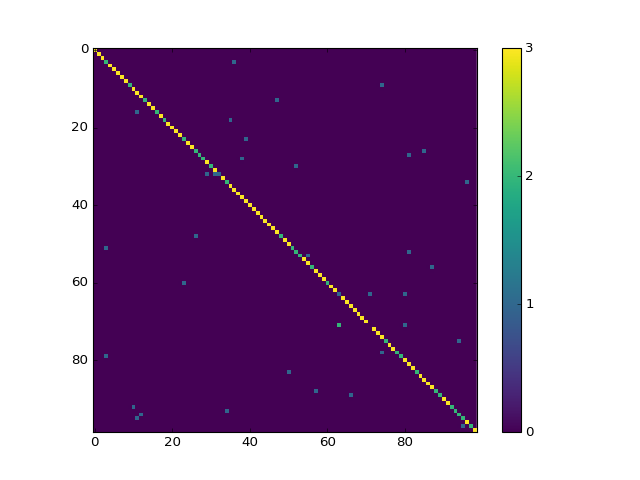

In [71]:
plt.figure()
plt.imshow(confusionMat, cmap='viridis', interpolation='none')
cb = plt.colorbar()
cb.set_ticks(range(4))


(1, 96, 96)


<IPython.core.display.Javascript object>


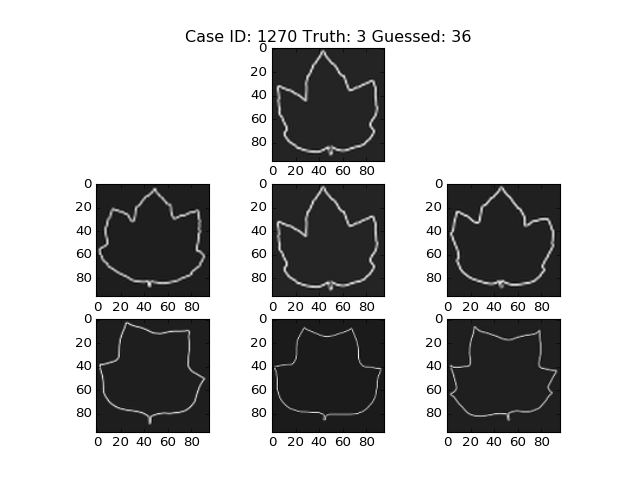

(1, 96, 96)


<IPython.core.display.Javascript object>


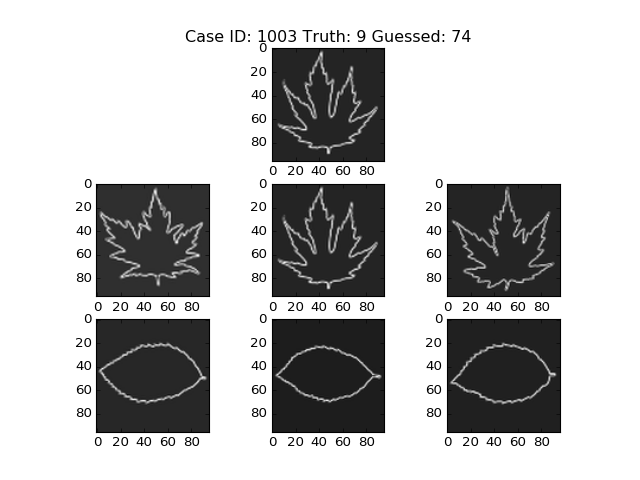

(1, 96, 96)


<IPython.core.display.Javascript object>


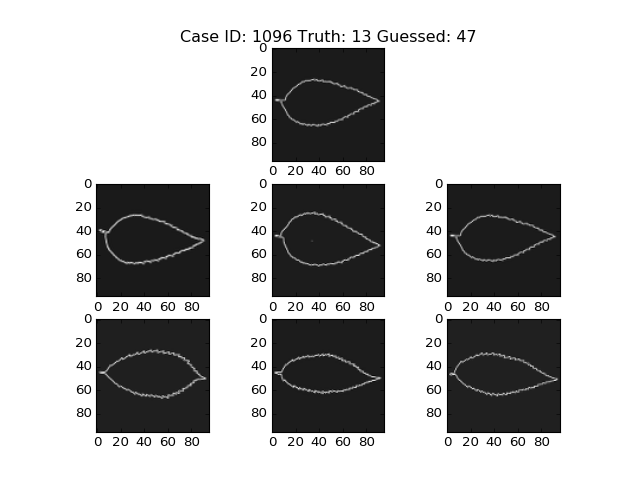

(1, 96, 96)


<IPython.core.display.Javascript object>


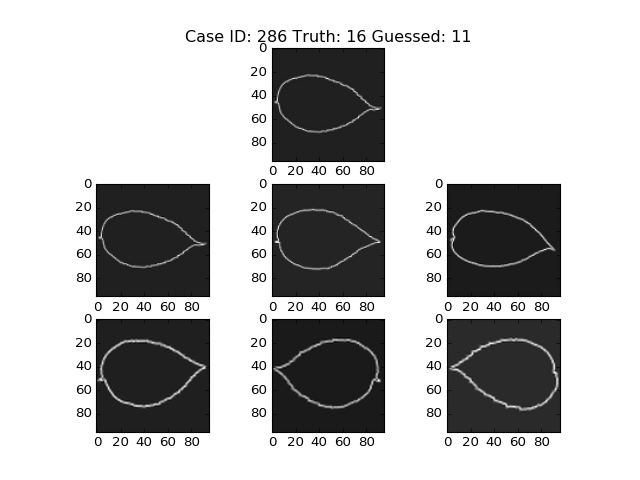

(1, 96, 96)


<IPython.core.display.Javascript object>


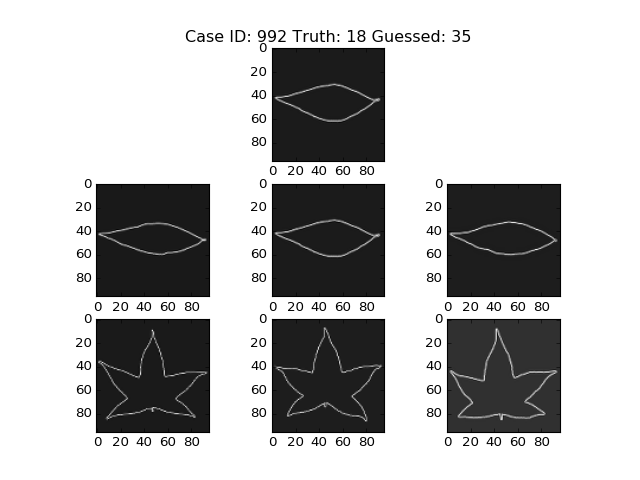

(1, 96, 96)


<IPython.core.display.Javascript object>


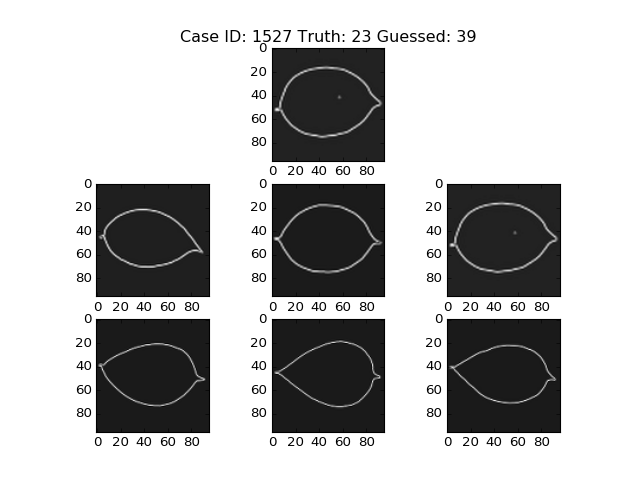

(1, 96, 96)


<IPython.core.display.Javascript object>


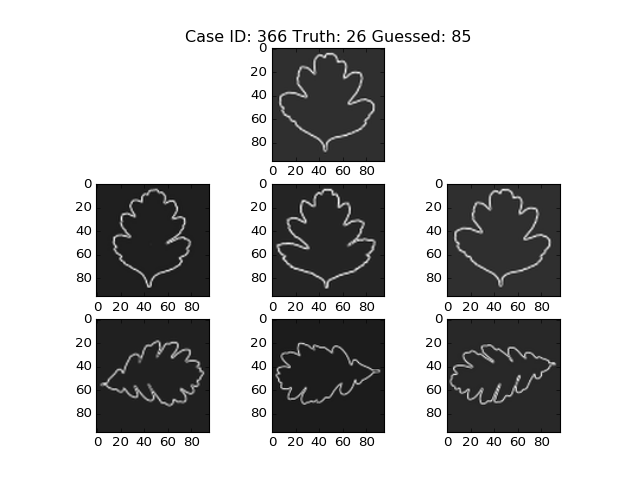

(1, 96, 96)


<IPython.core.display.Javascript object>


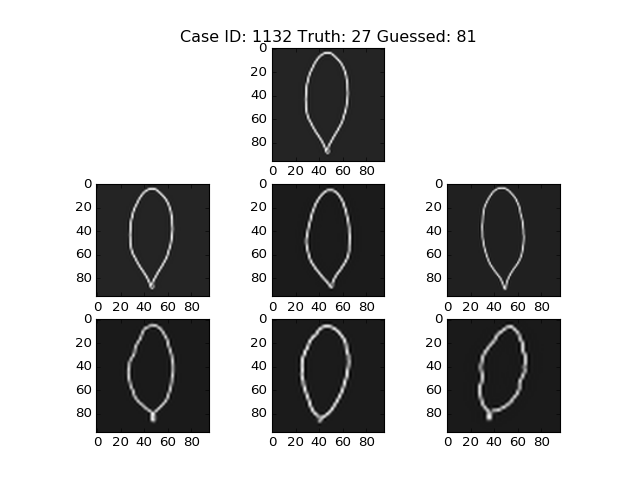

(1, 96, 96)


<IPython.core.display.Javascript object>


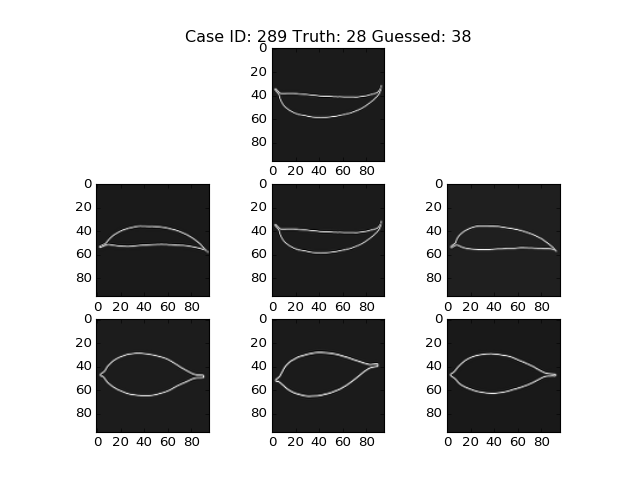

(1, 96, 96)


<IPython.core.display.Javascript object>


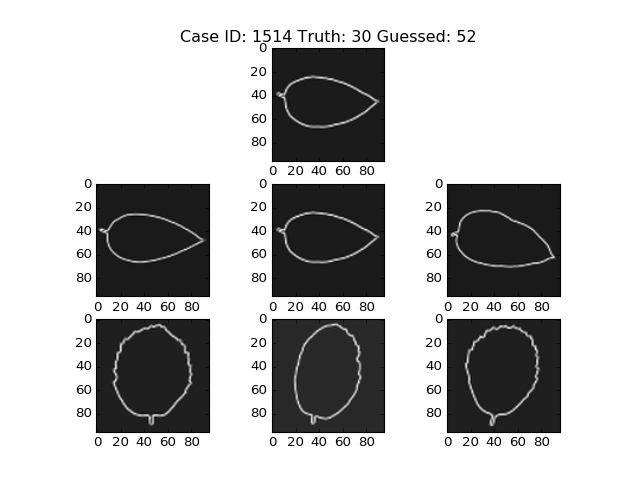

(1, 96, 96)


<IPython.core.display.Javascript object>


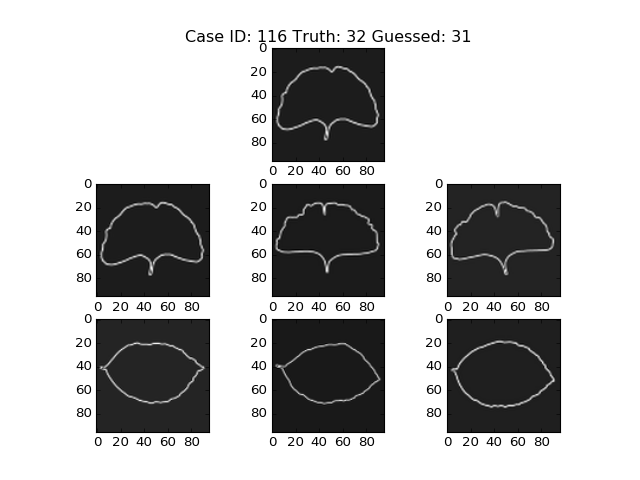

(1, 96, 96)


<IPython.core.display.Javascript object>


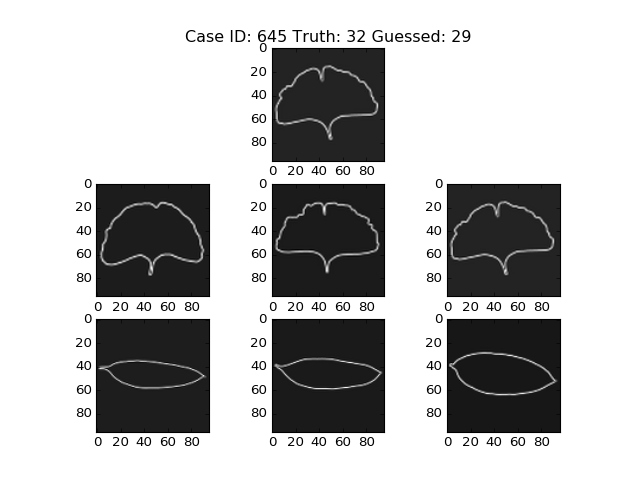

(1, 96, 96)


<IPython.core.display.Javascript object>


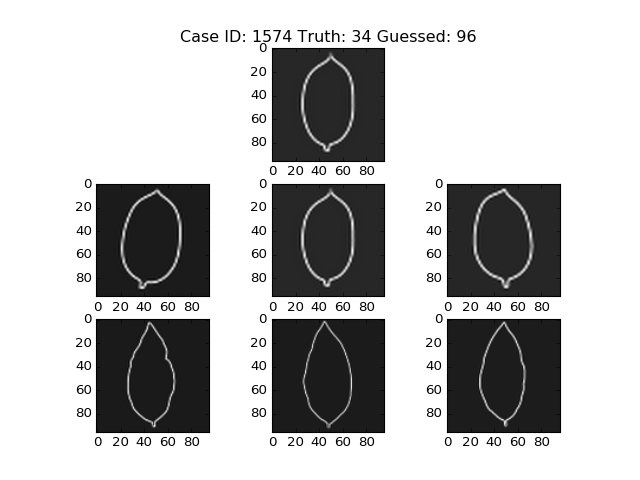

(1, 96, 96)


<IPython.core.display.Javascript object>


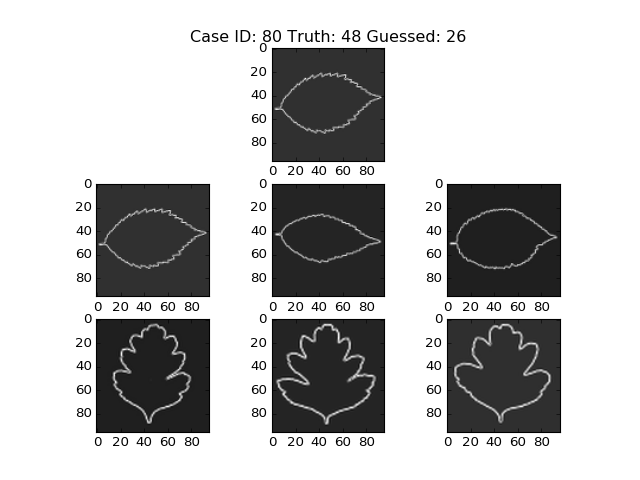

(1, 96, 96)


<IPython.core.display.Javascript object>


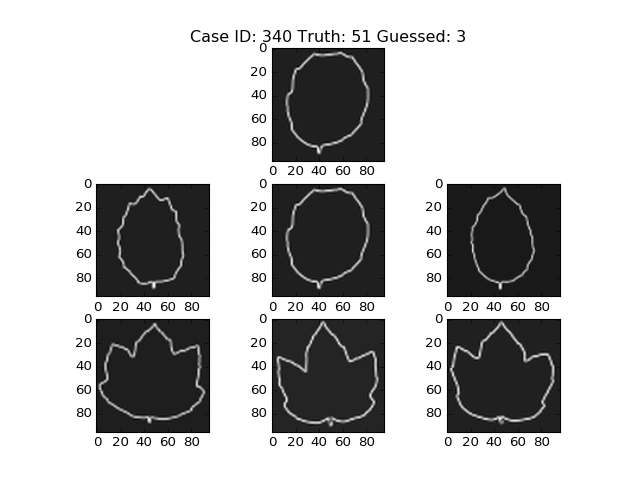

(1, 96, 96)


<IPython.core.display.Javascript object>


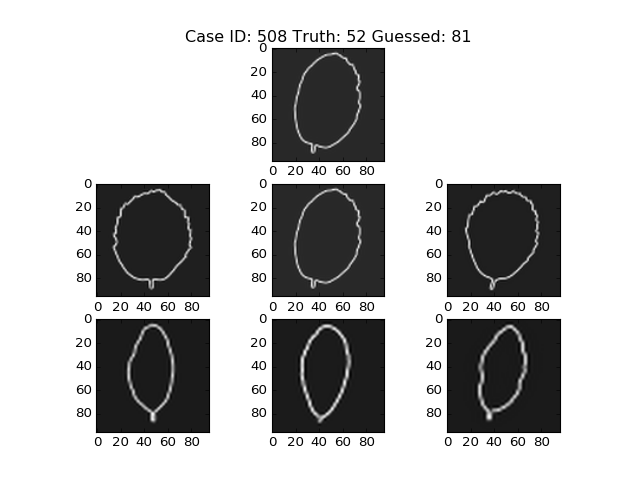

(1, 96, 96)


<IPython.core.display.Javascript object>


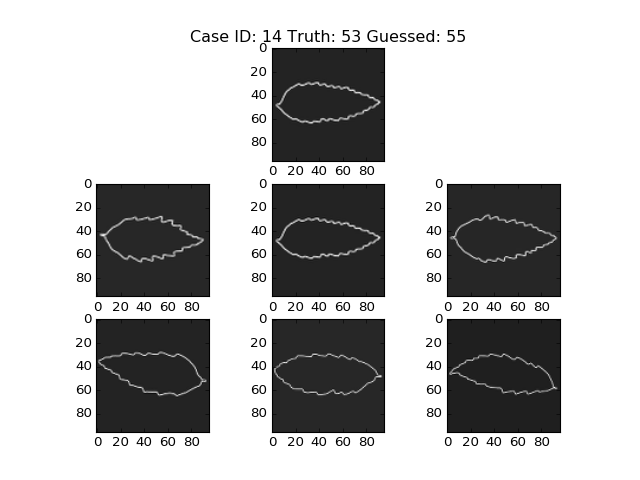

(1, 96, 96)


<IPython.core.display.Javascript object>


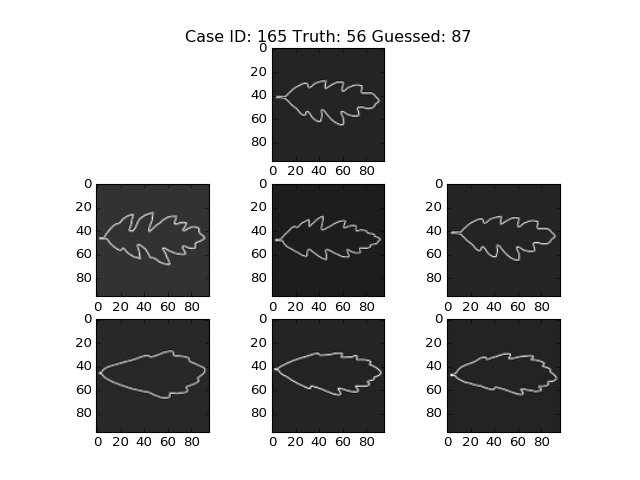

(1, 96, 96)


<IPython.core.display.Javascript object>


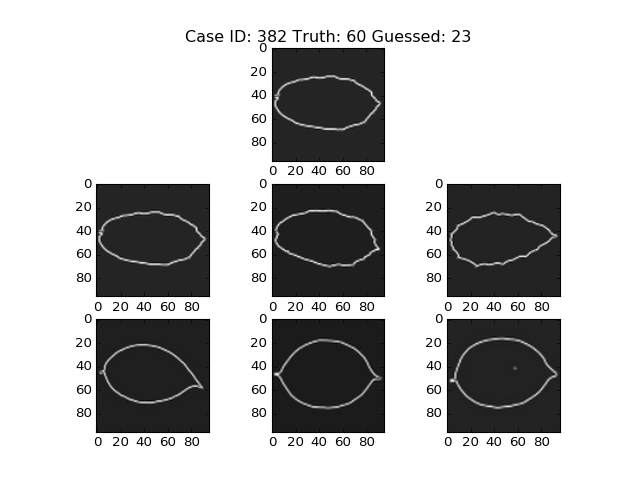

(1, 96, 96)


<IPython.core.display.Javascript object>


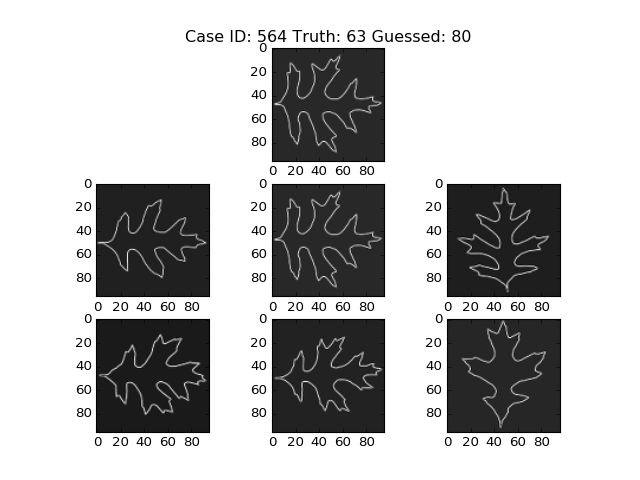

(1, 96, 96)


<IPython.core.display.Javascript object>


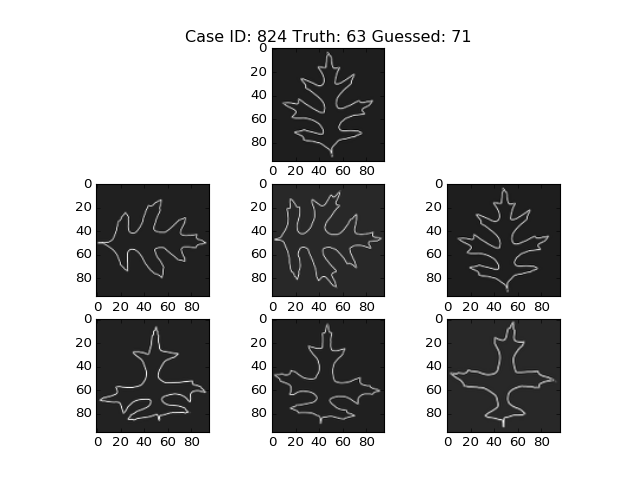

(1, 96, 96)


<IPython.core.display.Javascript object>


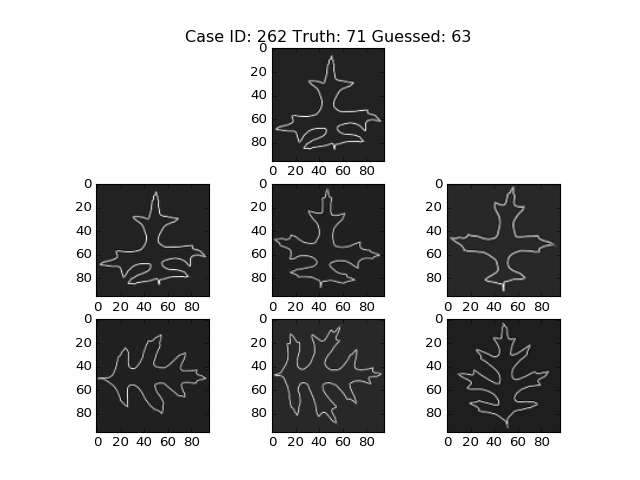

(1, 96, 96)


<IPython.core.display.Javascript object>


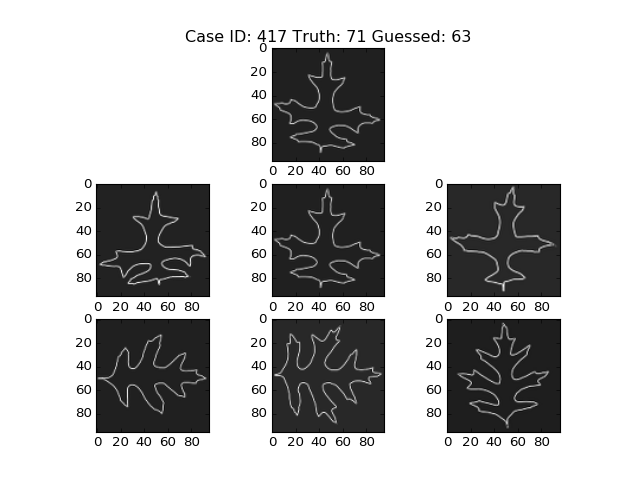

(1, 96, 96)


<IPython.core.display.Javascript object>


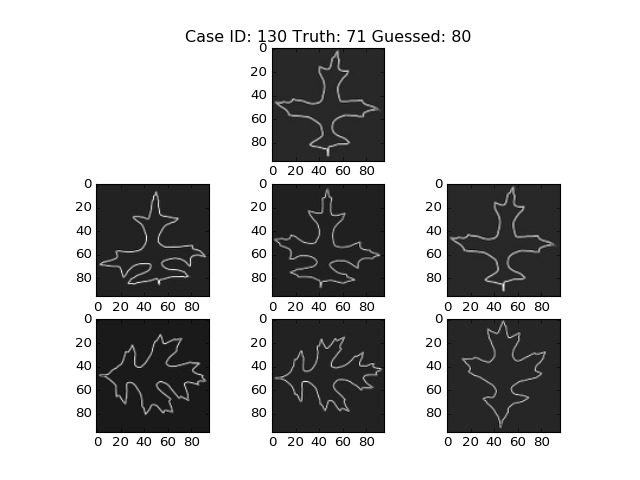

(1, 96, 96)


<IPython.core.display.Javascript object>


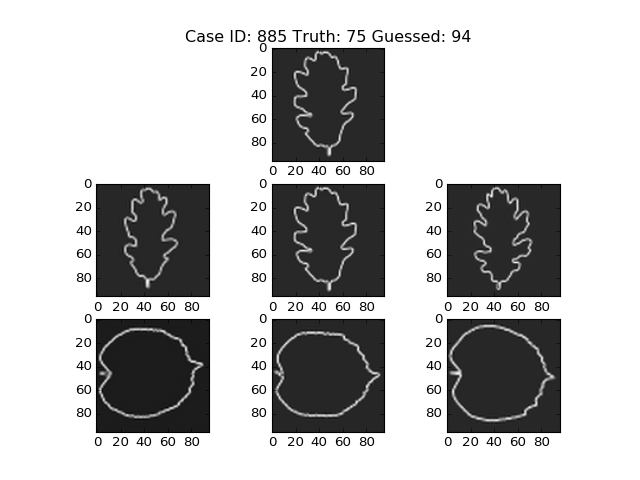

(1, 96, 96)


<IPython.core.display.Javascript object>


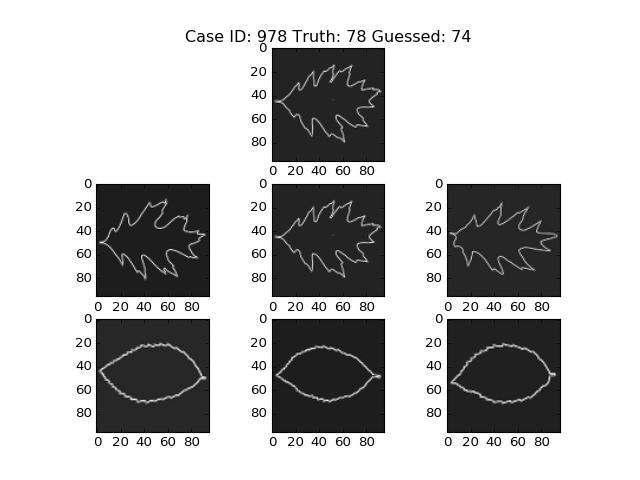

(1, 96, 96)


<IPython.core.display.Javascript object>


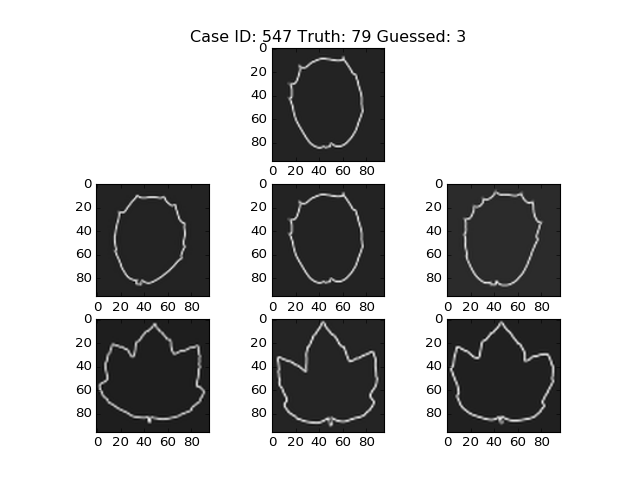

(1, 96, 96)


<IPython.core.display.Javascript object>


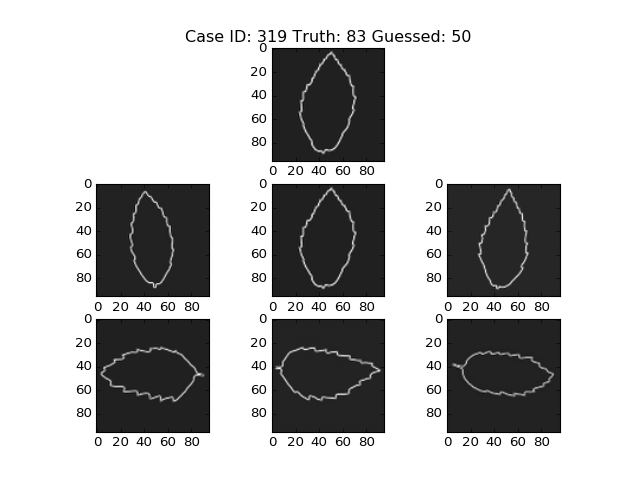

(1, 96, 96)


<IPython.core.display.Javascript object>


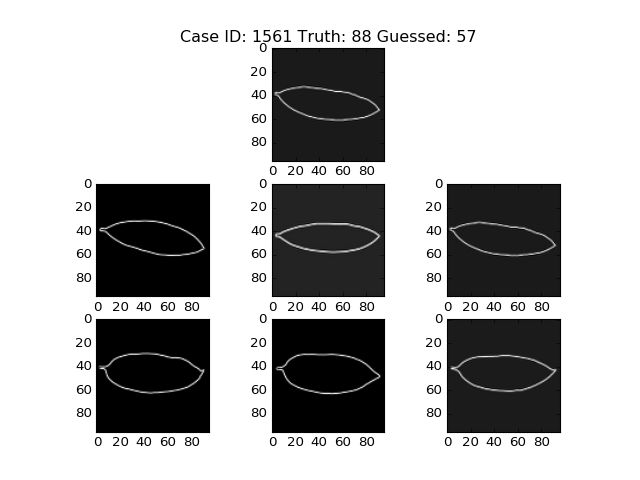

(1, 96, 96)


<IPython.core.display.Javascript object>


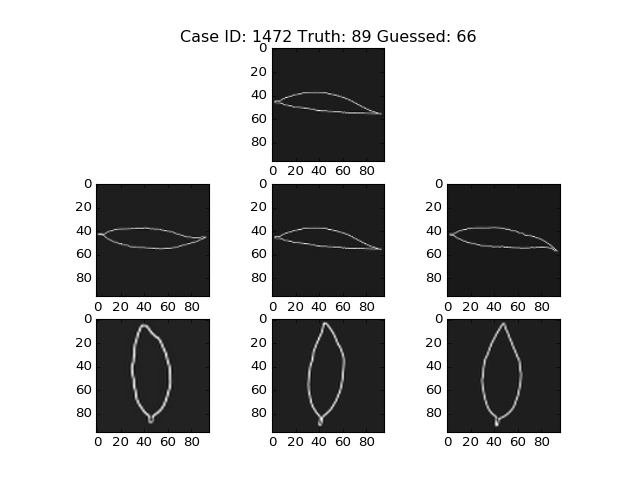

(1, 96, 96)


<IPython.core.display.Javascript object>


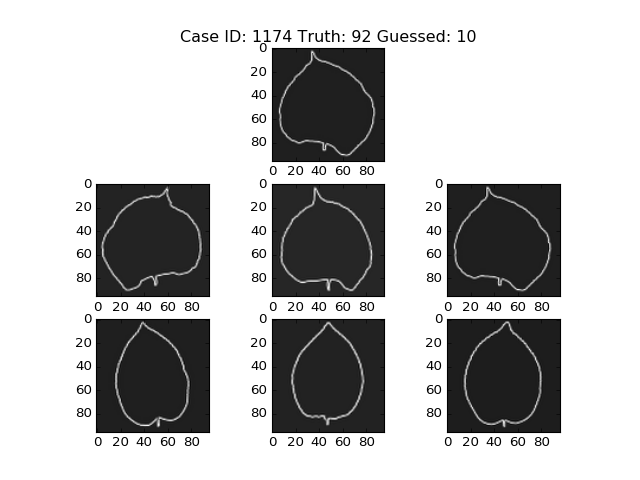

(1, 96, 96)


<IPython.core.display.Javascript object>


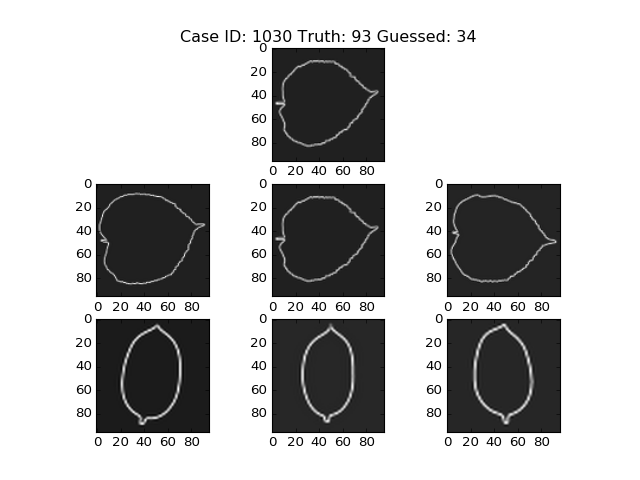

(1, 96, 96)


<IPython.core.display.Javascript object>


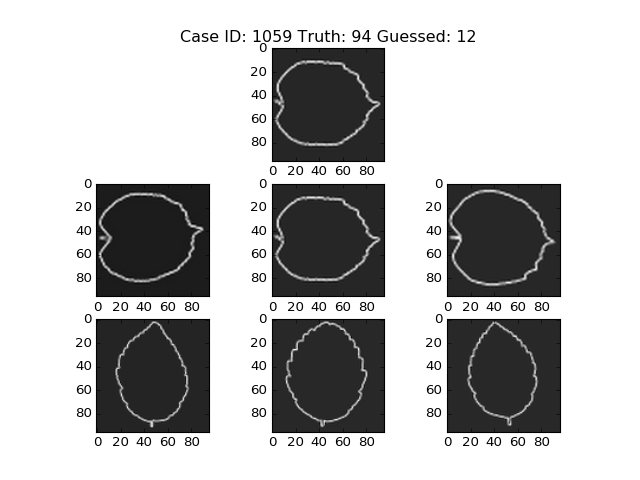

(1, 96, 96)


<IPython.core.display.Javascript object>


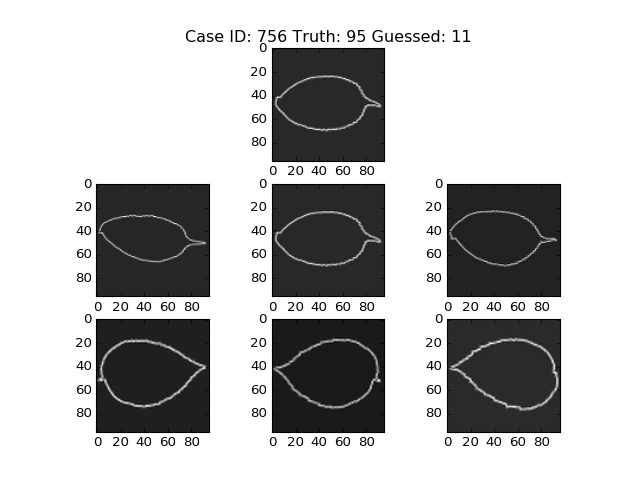

(1, 96, 96)


<IPython.core.display.Javascript object>


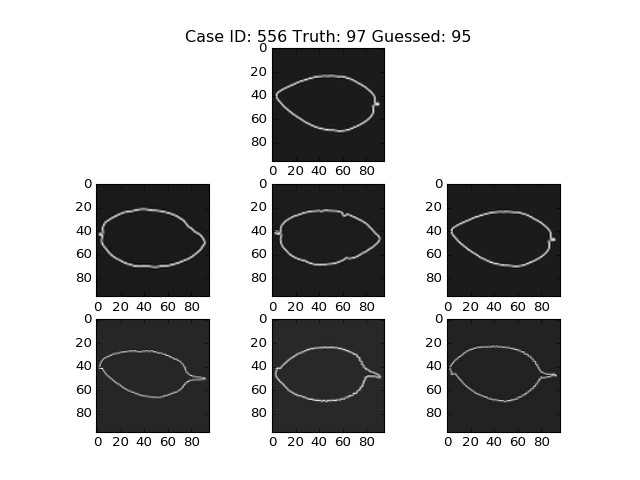

In [75]:
badGuesses = td.loc[td['classId'] != td['guessedLabel']]
for r in list(badGuesses.iterrows()):
    d = r[1]
    currCaseImg, _, _ = data.getTestData(caseId=d['caseId'])
    print currCaseImg.shape
    classId = d['classId']
    guessedLabel = d['guessedLabel']
    plt.figure()
    plt.subplot(3,3,2)
    plt.imshow(np.squeeze(currCaseImg), cmap='gray')
    plt.title('Case ID: {0} Truth: {1} Guessed: {2}'.format(d['caseId'], 
                                                            d['classId'],
                                                            d['guessedLabel']))
    sameClass = td.loc[td['classId'] == classId]
    badClass = td.loc[td['classId'] == guessedLabel]
    
    
    for i in range(3):
        plt.subplot(3,3, i+4)
        tmp, _, _ = data.getTestData(caseId=sameClass.iloc[i]['caseId'])
        plt.imshow(np.squeeze(tmp), cmap='gray')
        
        plt.subplot(3, 3, i+7)
        tmp, _, _ = data.getTestData(caseId=badClass.iloc[i]['caseId'])
        plt.imshow(np.squeeze(tmp), cmap='gray')

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(sess, 'trainedModel.ckpt')

In [ ]:
saver.restore(sess, 'trainedModel.ckpt')

testImg, testMerged, _ = test.getTestData()
whitenedTestImg = data.whitenImageSamples(testImg)
whitenedTestImg = np.expand_dims(whitenedTestImg, -1)
whitenedTestHist = data.whitenHistSamples(testMerged)

results = y_conv.eval(feed_dict={
    x: whitenedTestImg,
    hists: whitenedTestHist,
    keep_prob: 1.0
})

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())

<IPython.core.display.Javascript object>


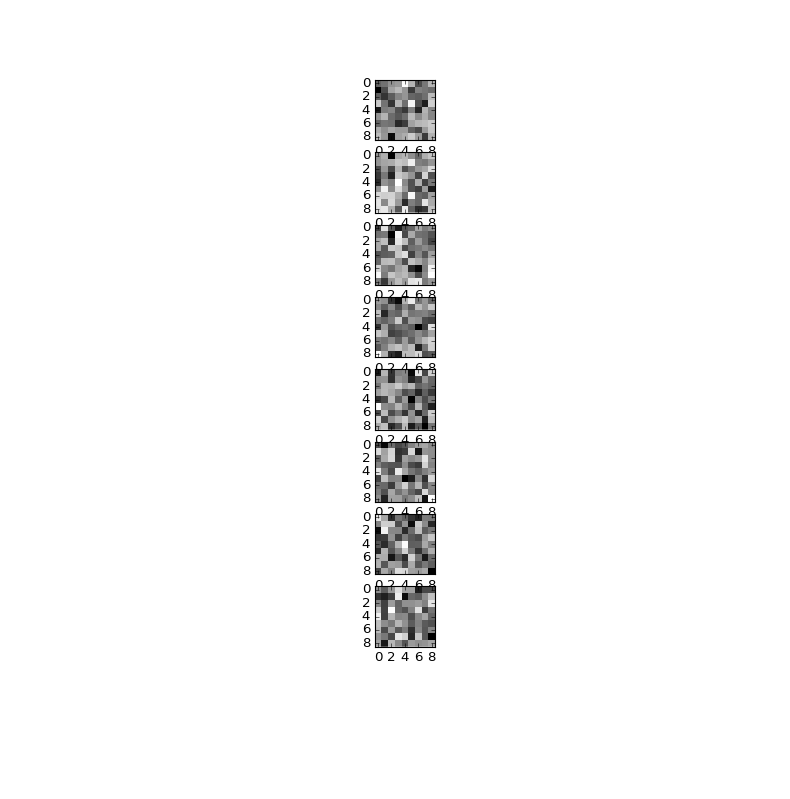

<IPython.core.display.Javascript object>


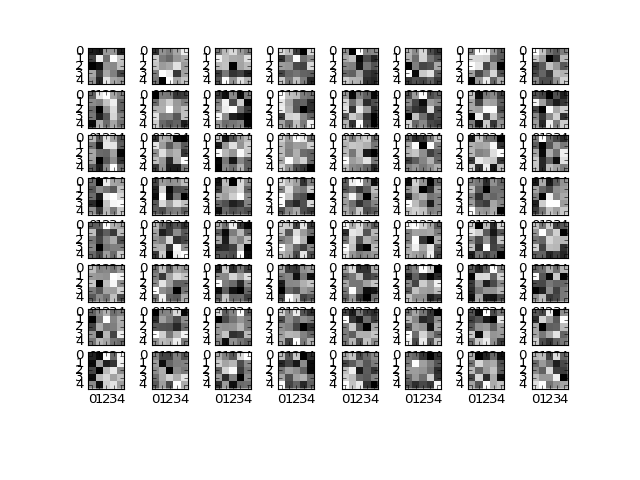

In [73]:
wConv1Val = W_conv1.eval()
wConv2Val = W_conv2.eval()
numFilters = wConv1Val.shape[-1]

for d in [wConv1Val, wConv2Val]:
    plt.figure()
    numFilters = d.shape[-1]
    numInputs = d.shape[-2]
    for i in range(numInputs):
        for j in range(numFilters):
            plt.subplot((numFilters * numInputs + numInputs) / numInputs , numInputs, i * numFilters + j + 1)
            plt.imshow(np.squeeze(d[:,:,i,j]), cmap='gray', interpolation='none')

In [ ]:
unprocessed, labelMap = readInFile('data/train.csv', preprocess=False)

<IPython.core.display.Javascript object>


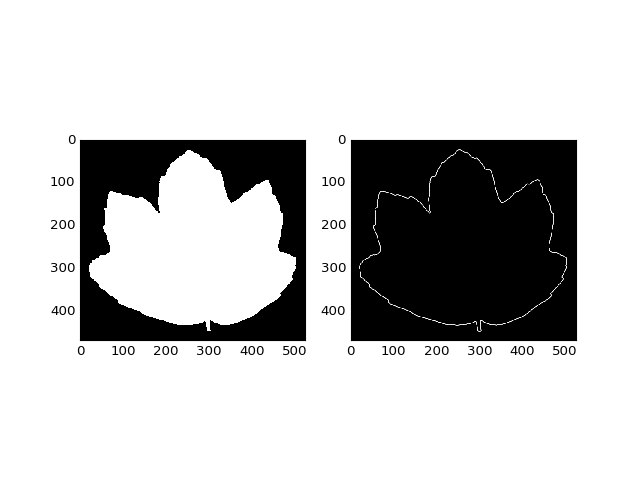

<IPython.core.display.Javascript object>


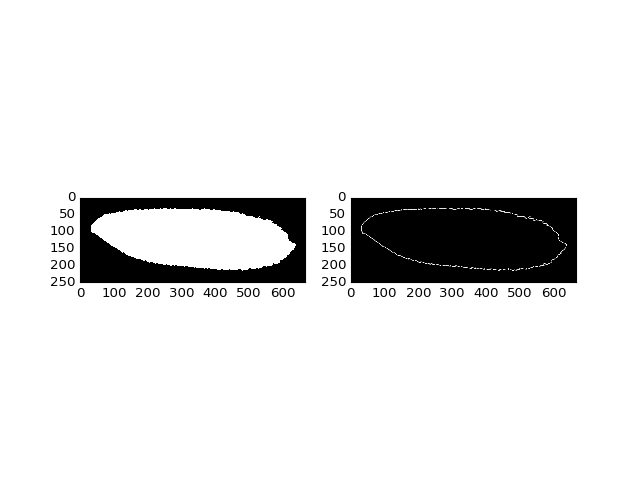

<IPython.core.display.Javascript object>


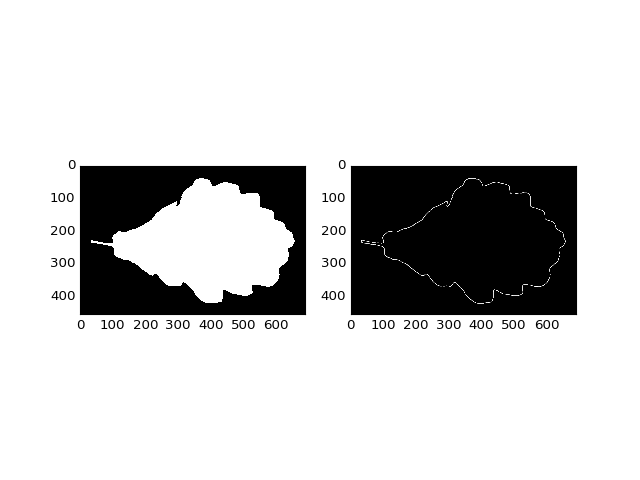

<IPython.core.display.Javascript object>


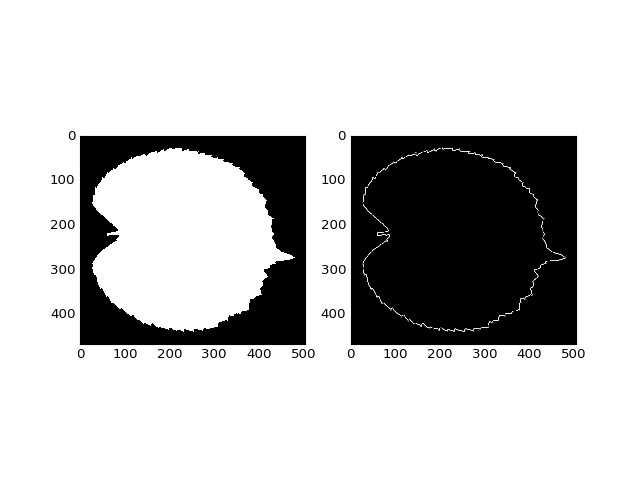

<IPython.core.display.Javascript object>


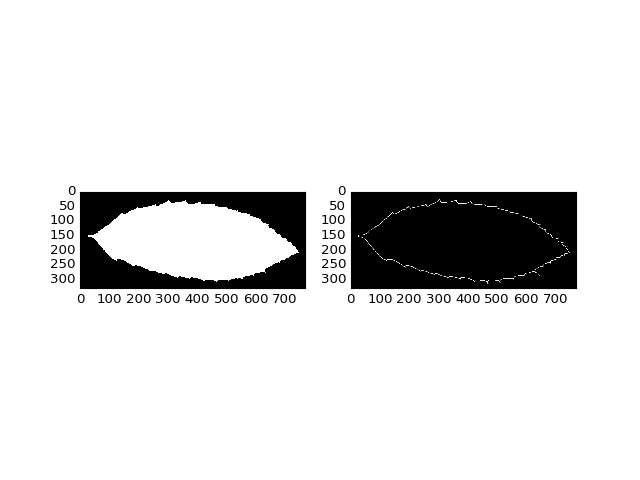

<IPython.core.display.Javascript object>


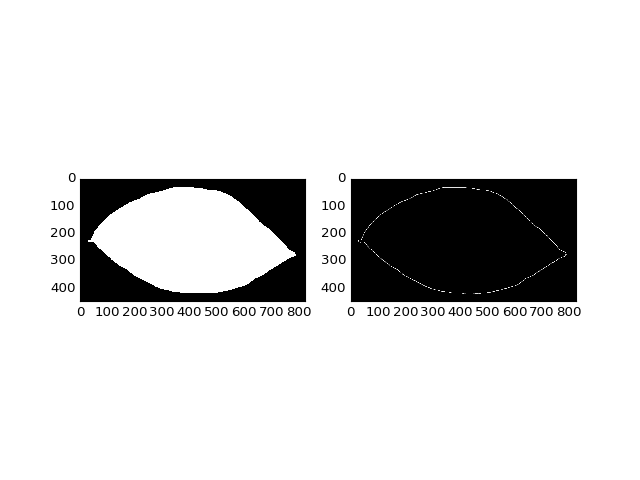

<IPython.core.display.Javascript object>


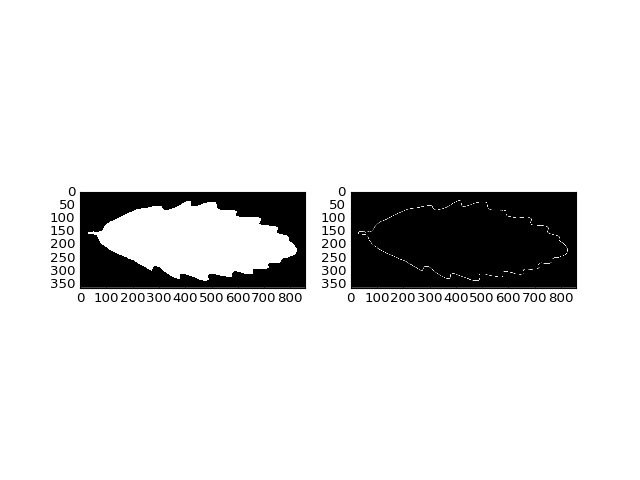

<IPython.core.display.Javascript object>


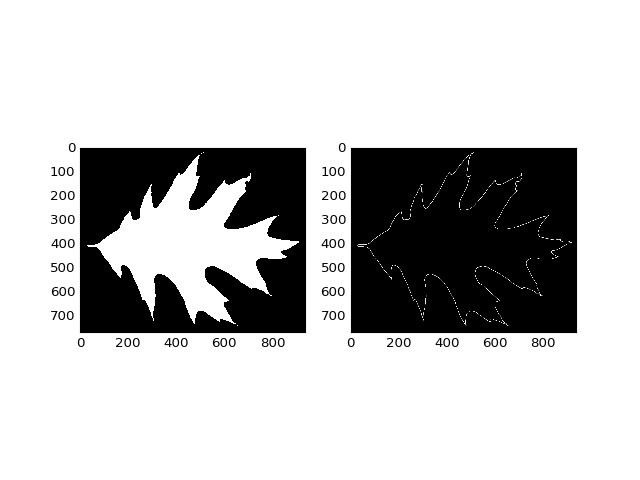

<IPython.core.display.Javascript object>


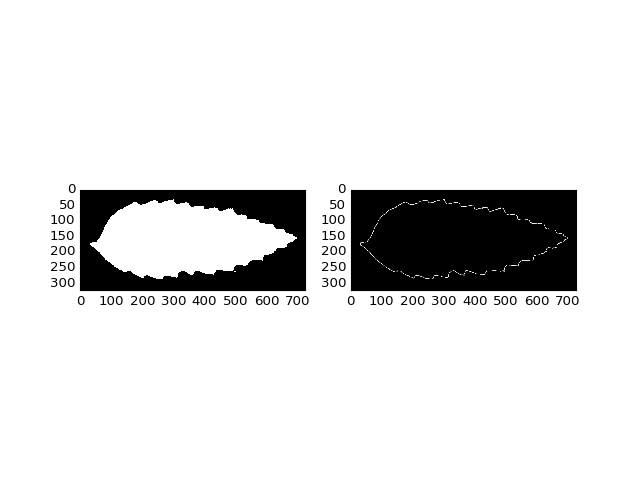

<IPython.core.display.Javascript object>


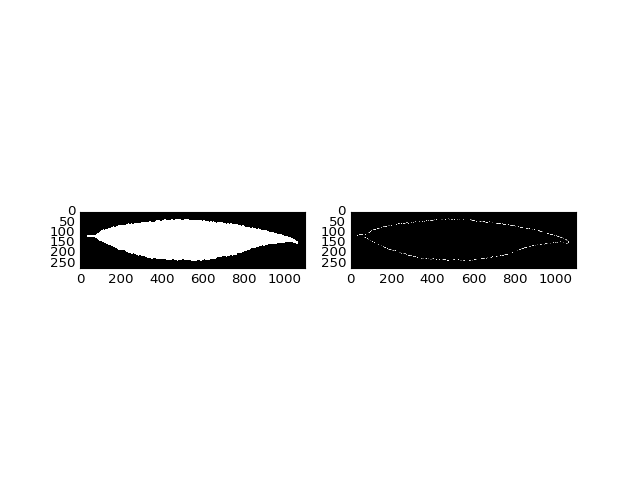

In [56]:
for i in range(10):
    currImg = unprocessed.iloc[i]['img']
    blurred = ndimage.gaussian_filter(currImg, 3)
    sobX = ndimage.sobel(currImg, axis=0)
    sobY = ndimage.sobel(currImg, axis=1)
    sobMag = np.sqrt(sobX ** 2 + sobY **2)
#     edgeFiltered = 
    plt.figure()
    plt.subplot(121)
    plt.imshow(currImg, cmap='gray', interpolation='none')
    plt.subplot(122)
    plt.imshow(sobMag, cmap='gray', interpolation='none')
#     plt.subplot(133)
#     plt.imshow(sobY, cmap='gray', interpolation='none')

1584    2                                                                                                                                     239               258                           306                                                   376                                                                              493                                                                      609                                                                                                                                                                                                                                                                                                     1048                                                  1145                                                                1245                                                                                                                                                                                    